In [1]:
# https://github.com/pytorch/examples/blob/master/mnist/main.py
from __future__ import print_function
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import PIL
from random import shuffle
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import random
import pickle

In [2]:
with open('dataconvall.pt', 'rb') as f:
    data = pickle.load(f)
    
with open('labelsall.pt', 'rb') as f:
    labels = pickle.load(f)
    
with open('datavalconvall.pt', 'rb') as f:
    dataVal = pickle.load(f)
    
with open('labelsval.pt', 'rb') as f:
    labelsVal = pickle.load(f)

with open('imglist.pt', 'rb') as f:
    images = pickle.load(f)

In [3]:
class AffonsoNet(nn.Module):

    def __init__(self,dropout = 0.5):
        super(AffonsoNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, kernel_size=10)
        self.conv2 = nn.Conv2d(20, 25, kernel_size=10)
        self.fc1 = nn.Linear(14875,4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 4)
        self.mp = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        in_size = x.size(0)
        x = self.mp(x)
        x = self.mp(x)
        x = self.dropout(torch.relu(self.conv1(x)))
        x = self.mp(x)
        x = self.dropout(torch.relu(self.conv2(x)))
        x = self.mp(x)
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return torch.log_softmax(x,1)


In [4]:
class AutoUXDataset(Dataset):
    def __init__(self, data, labels,isTrain=True,isVal=False):
        self.data = data
        self.labels = labels
        self.isTrain = isTrain
        self.isVal = isVal
        if isVal:
            self.testX = torch.from_numpy(np.asarray(data,dtype=np.uint8)).type('torch.FloatTensor')
            self.testY = torch.from_numpy(np.asarray(labels,dtype=np.uint8)).type('torch.LongTensor')
        else:
            self.setTest(0)

    def __len__(self):
        if self.isTrain:
            return len(self.trainX)
        else:
            return len(self.testX)

    def setTest(self,testI):
        if self.isVal:
            d = self.data
            l = self.labels
            self.testX = torch.from_numpy(np.asarray(d,dtype=np.uint8)).type('torch.FloatTensor')
            self.testY = torch.from_numpy(np.asarray(l,dtype=np.uint8)).type('torch.LongTensor')
            return
        d = np.empty((0,3,384,683),int)
        l = []
        for i in range(5):
            if i != testI:
                d = np.append(d,self.data[i],axis=0)
                l += self.labels[i]
            else:
                self.testX = torch.from_numpy(np.asarray(data[i],dtype=np.uint8)).type('torch.FloatTensor')
                self.testY = torch.from_numpy(np.asarray(labels[i],dtype=np.uint8)).type('torch.LongTensor')
                
        self.trainX = torch.from_numpy(np.asarray(d,dtype=np.uint8)).type('torch.FloatTensor')
        self.trainY = torch.from_numpy(np.asarray(l,dtype=np.uint8)).type('torch.LongTensor')
    
    def __getitem__(self, idx):
        if self.isTrain:
            return {"img" : self.trainX[idx], "label": self.trainY[idx]}
        else:
            return {"img" : self.testX[idx], "label": self.testY[idx]}

In [5]:
def train_batch(model,crit,opt,x, y):
    opt.zero_grad()
    y_pred = model(x)
    loss = crit(y_pred, y)
    loss.backward()
    opt.step() 
    return loss.item(),torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

def train(model,crit,opt,dataload,disable=False):
    # Training loop
    dloss, dacc = 0,0
    for s in tqdm(dataload,disable=disable):
        x, y = s.values()
        x = x.cuda()
        y = y.cuda()
        lo, acc = train_batch(model,crit,opt,x,y)
        dloss += lo
        dacc += acc
    dloss /= len(dataload)
    dacc /= len(dataload)
    return dloss,dacc

def test_batch(model,crit,x, y):
    y_pred = model(x)
    loss = crit(y_pred, y)
    return loss.item(),torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

def test(model,crit,dataload,disable=False):
    # Training loop
    dloss, dacc = 0,0
    with torch.no_grad():
        for s in tqdm(dataload,disable=disable):
            x, y = s.values()
            x = x.cuda()
            y = y.cuda()
            lo, acc = test_batch(model,crit,x,y)
            dloss += lo
            dacc += acc
    dloss /= len(dataload)
    dacc /= len(dataload)
    return dloss,dacc

Batch Size: 24
Weight Decay: 1.1101254708379769
Dropout: 0.5068946035196518

Fold 1
Epoch Train Loss: 0.769170  Epoch Train Accuracy: 49.444444  Epoch Test Loss: 0.789210  Epoch Test Accuracy: 53.273810
Epoch Train Loss: 0.780171  Epoch Train Accuracy: 49.583333  Epoch Test Loss: 0.798603  Epoch Test Accuracy: 50.372024
Epoch Train Loss: 0.778336  Epoch Train Accuracy: 52.272727  Epoch Test Loss: 0.798675  Epoch Test Accuracy: 47.842262
Epoch Train Loss: 0.789241  Epoch Train Accuracy: 49.873737  Epoch Test Loss: 0.761745  Epoch Test Accuracy: 49.925595
Epoch Train Loss: 0.772437  Epoch Train Accuracy: 50.593434  Epoch Test Loss: 0.770426  Epoch Test Accuracy: 43.675595
Epoch Train Loss: 0.765223  Epoch Train Accuracy: 50.467172  Epoch Test Loss: 0.803715  Epoch Test Accuracy: 39.508929
Epoch Train Loss: 0.777905  Epoch Train Accuracy: 48.055556  Epoch Test Loss: 0.786440  Epoch Test Accuracy: 46.949405
Epoch Train Loss: 0.778029  Epoch Train Accuracy: 55.467172  Epoch Test Loss: 0.816

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Fold 2
Epoch Train Loss: 0.778296  Epoch Train Accuracy: 47.939560  Epoch Test Loss: 0.758436  Epoch Test Accuracy: 42.307692
Epoch Train Loss: 0.789937  Epoch Train Accuracy: 49.862637  Epoch Test Loss: 0.755806  Epoch Test Accuracy: 51.648352
Epoch Train Loss: 0.774968  Epoch Train Accuracy: 49.175824  Epoch Test Loss: 0.760308  Epoch Test Accuracy: 48.251748
Epoch Train Loss: 0.788813  Epoch Train Accuracy: 48.351648  Epoch Test Loss: 0.766436  Epoch Test Accuracy: 45.504496
Epoch Train Loss: 0.808858  Epoch Train Accuracy: 49.862637  Epoch Test Loss: 0.792744  Epoch Test Accuracy: 47.552448
Epoch Train Loss: 0.786417  Epoch Train Accuracy: 50.824176  Epoch Test Loss: 0.767631  Epoch Test Accuracy: 47.052947
Epoch Train Loss: 0.780729  Epoch Train Accuracy: 50.412088  Epoch Test Loss: 0.773347  Epoch Test Accuracy: 44.505495
Epoch Train Loss: 0.772486  Epoch Train Accuracy: 53.159341  Epoch Test Loss: 0.809263  Epoch Test Accuracy: 45.604396
Epoch Train Loss: 0.791334  Epoch Train A

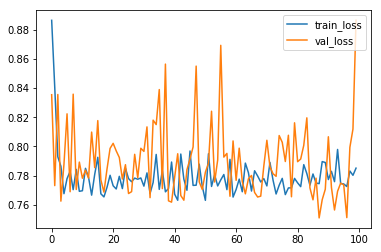

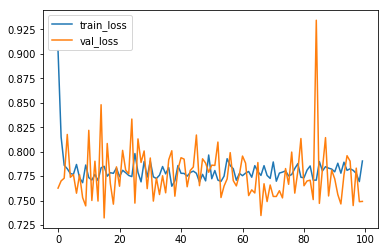

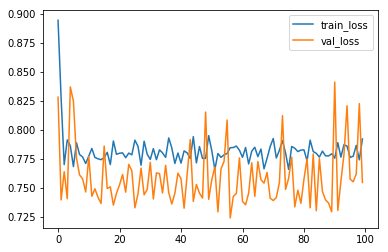

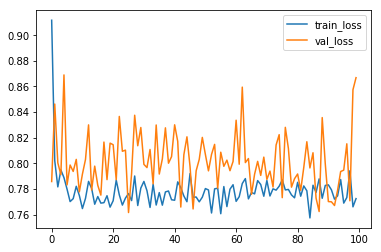

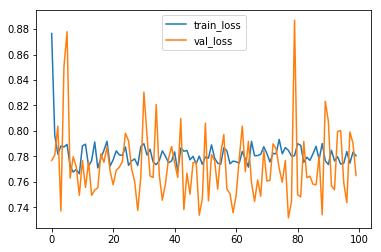

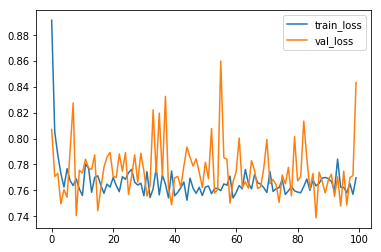

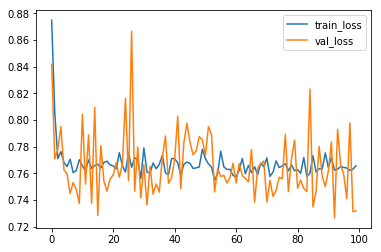

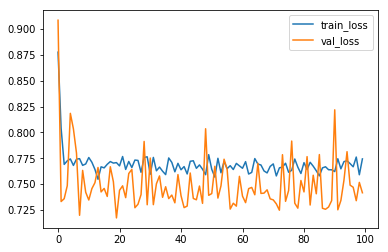

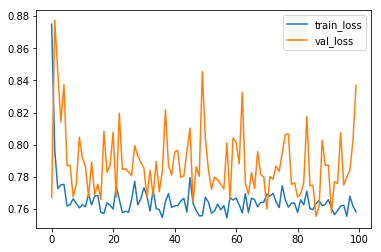

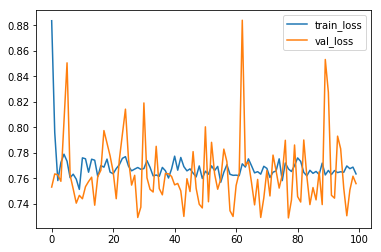

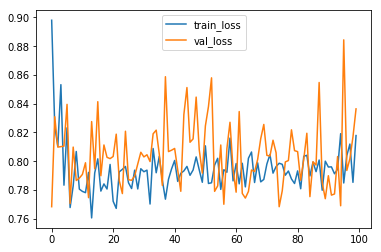

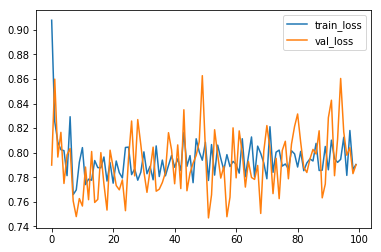

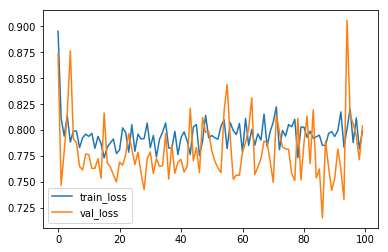

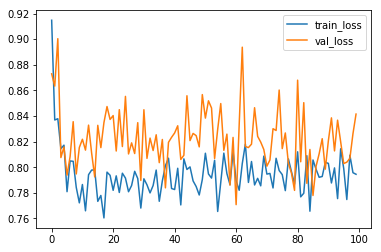

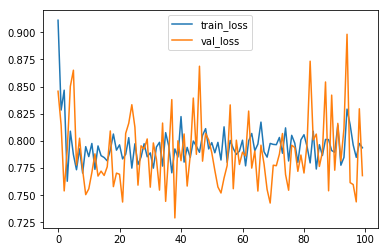

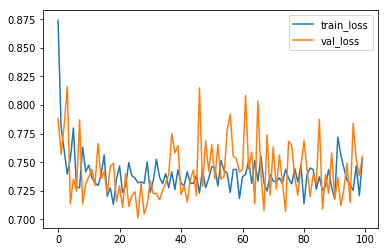

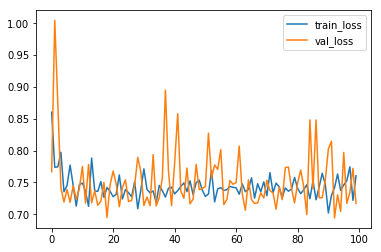

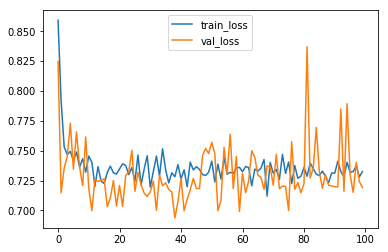

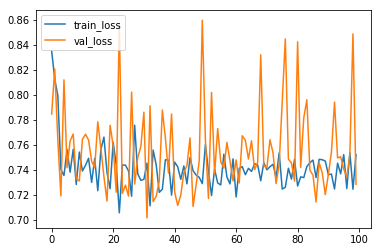

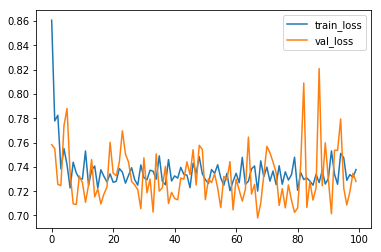

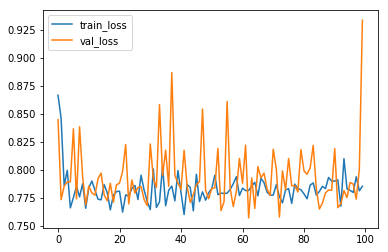

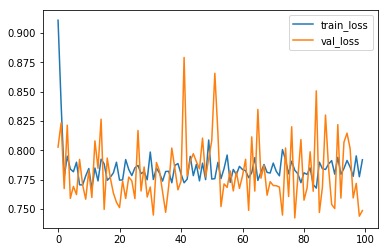

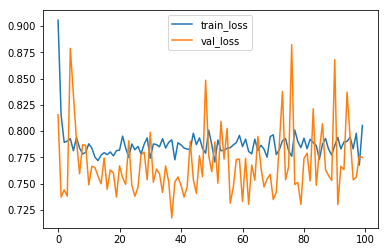

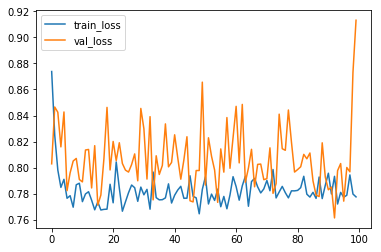

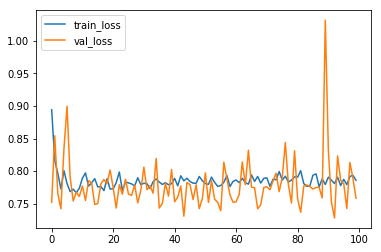

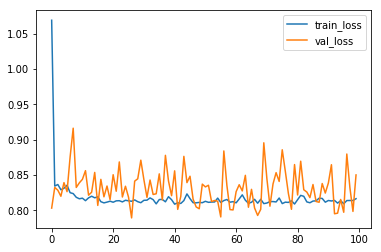

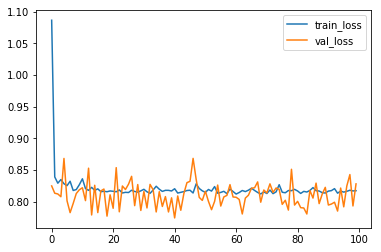

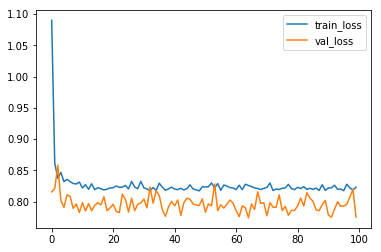

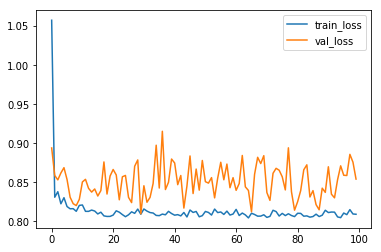

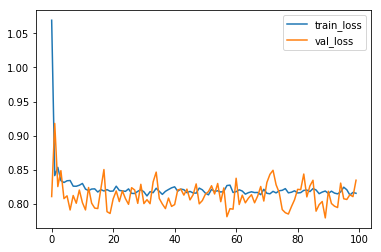

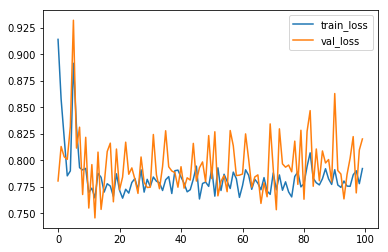

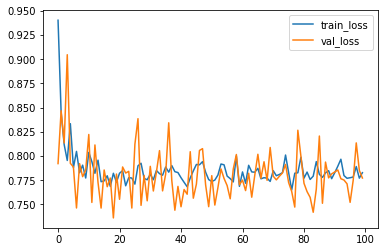

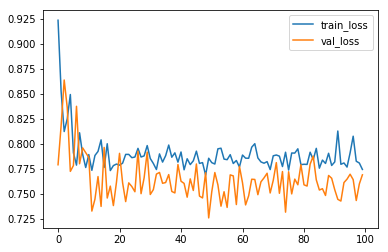

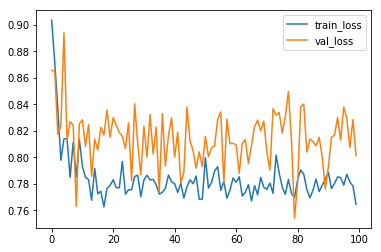

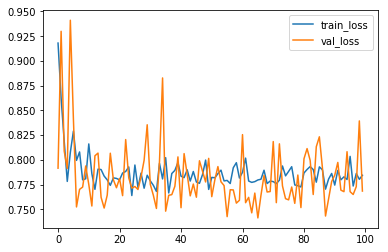

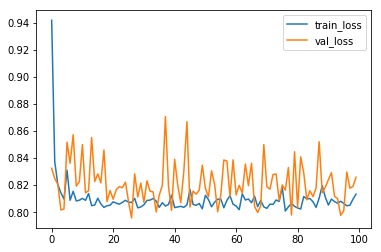

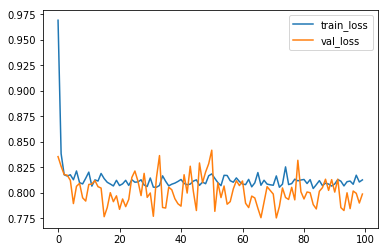

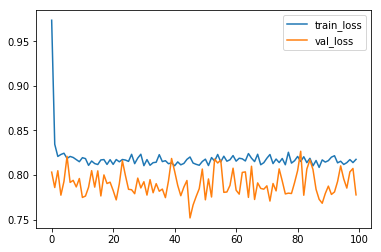

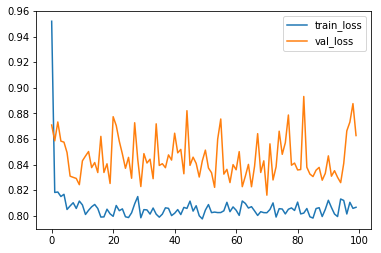

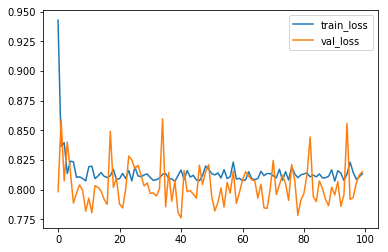

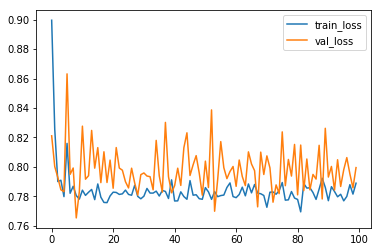

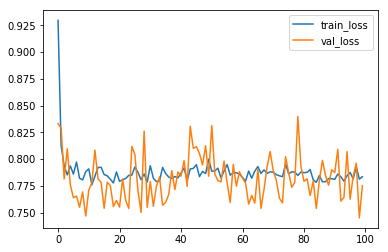

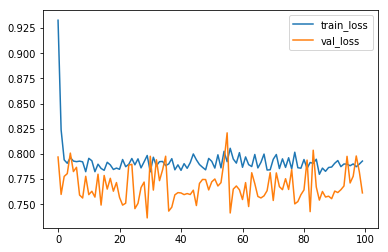

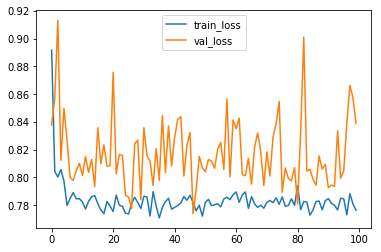

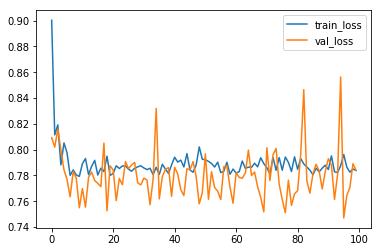

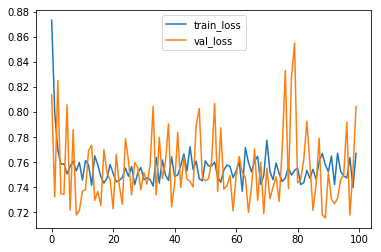

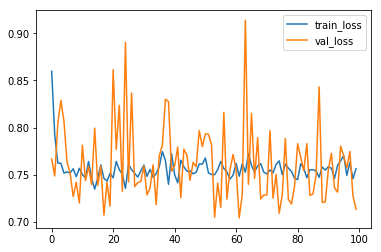

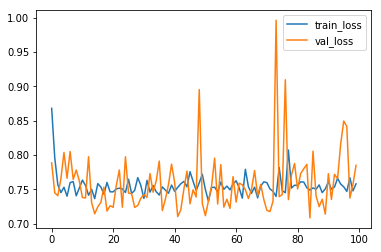

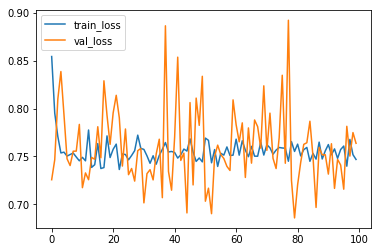

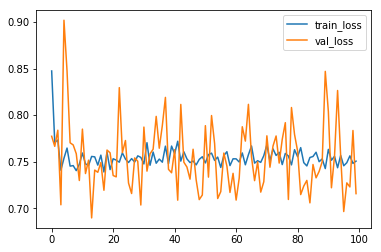

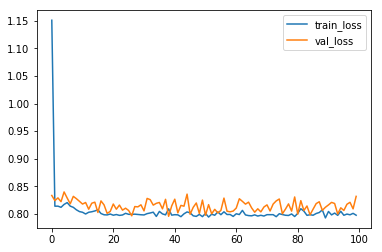

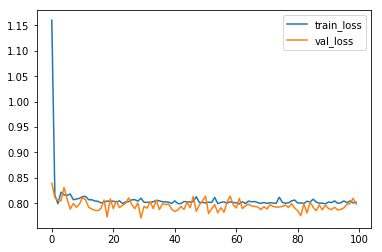

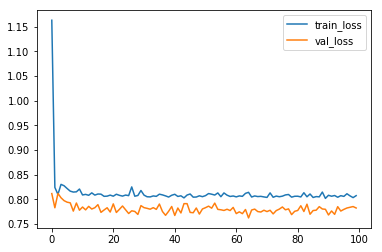

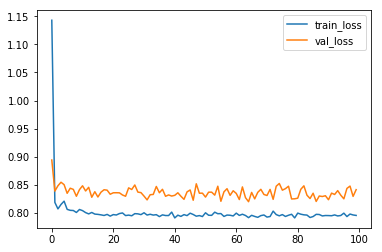

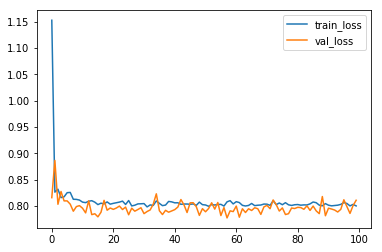

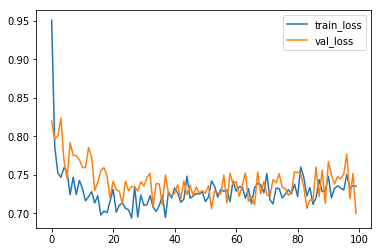

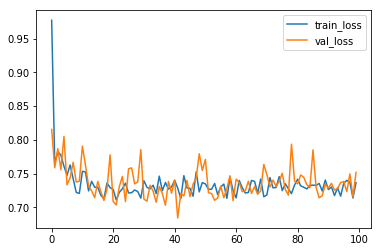

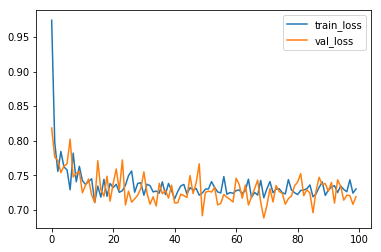

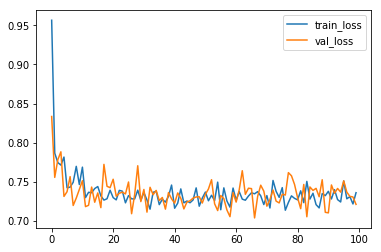

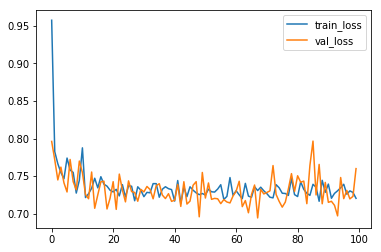

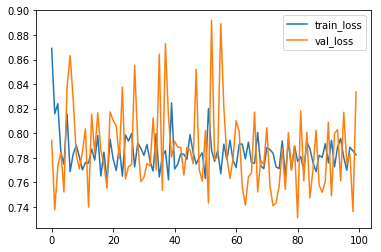

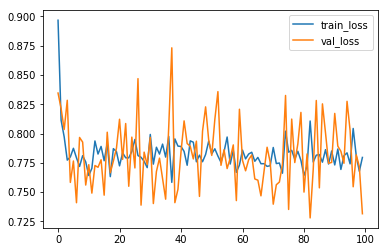

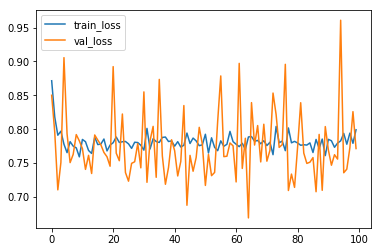

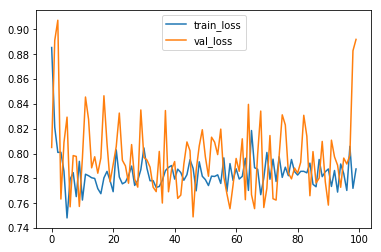

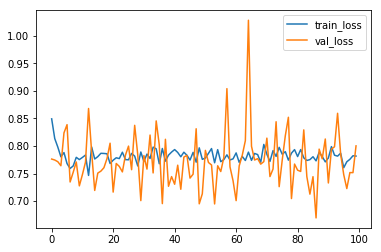

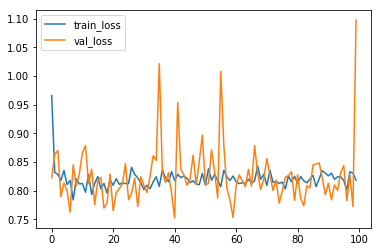

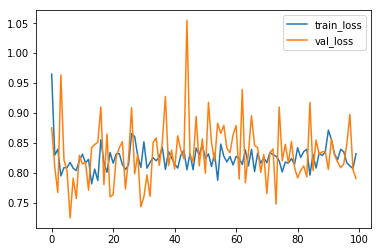

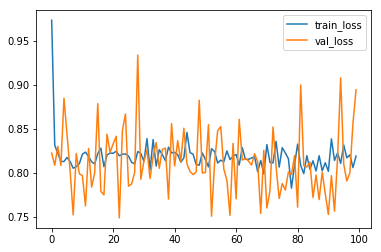

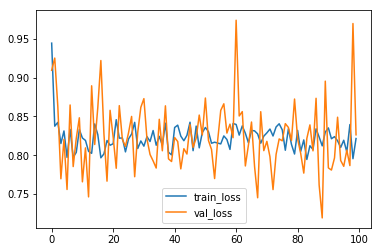

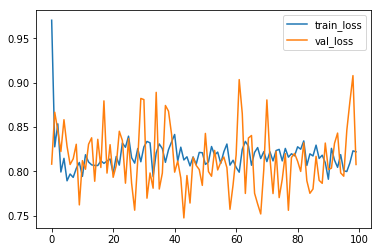

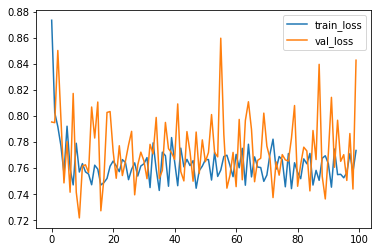

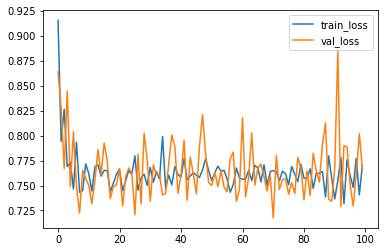

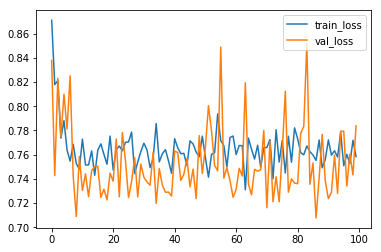

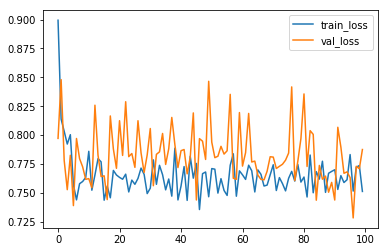

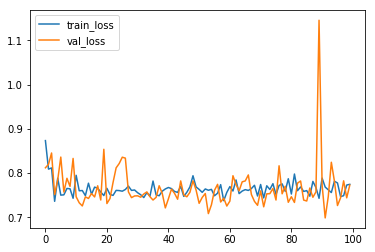

In [6]:
my_data = AutoUXDataset(data,labels,True)
my_test = AutoUXDataset(data,labels,False)

num_attempts = 15

random.seed(4815162352)
batch_sizes = [int(np.round(2 ** random.uniform(4,7))) for i in range(num_attempts)]
dropouts = [random.uniform(0,0.9) for i in range(num_attempts)]
weight_decays = [np.exp(random.normalvariate(0,0.5)) for i in range(num_attempts)]
stats = []
fbs,fwd,fd = 0,0,0
best_acc = -999

disable = True
epochs = 100
every_other = 10

for i in range(len(batch_sizes)):
    avedloss, avedacc, avevloss, avevacc = 0,0,0,0
    batch_size = batch_sizes[i]
    weight_decay = weight_decays[i]
    dropout = dropouts[i]
    print("Batch Size: {}\nWeight Decay: {}\nDropout: {}\n".format(batch_size,weight_decay,dropout))
    for i in range(5):
        torch.manual_seed(4815162342)
        model = AffonsoNet(dropout=dropout).cuda()
        optimizer = optim.Adam(model.parameters(), lr=3e-4,weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()
        dlosscurve = []
        dacccurve = []
        vlosscurve = []
        vacccurve = []
        print("Fold %d" % (i + 1))
        my_data.setTest(i)
        my_test.setTest(i)

        my_loader = DataLoader(my_data, batch_size=batch_size,
                                shuffle=True)
        my_test_loader = DataLoader(my_test, batch_size=batch_size,
                                shuffle=True)
        for j in range(epochs):
            dloss, dacc = train(model,criterion,optimizer,my_loader,disable)
            vloss, vacc = test(model,criterion,my_test_loader,disable)
            dlosscurve.append(dloss)
            dacccurve.append(dacc)
            vlosscurve.append(vloss)
            vacccurve.append(vacc)
            if j % every_other == every_other - 1:
                print("Epoch Train Loss: {:.6f}  Epoch Train Accuracy: {:.6f}  Epoch Test Loss: {:.6f}  Epoch Test Accuracy: {:.6f}".format(dloss,dacc * 100,vloss,vacc * 100))
        df = pd.DataFrame(data={"train_loss": dlosscurve, "val_loss": vlosscurve})
        df.plot.line()
        avedloss += dloss
        avedacc += dacc
        avevloss += vloss
        avevacc += vacc
    avedloss /= 5
    avedacc /= 0.05
    avevloss /= 5
    avevacc /= 0.05
    if avevacc > best_acc:
        fbs,fwd,fd,best_acc = batch_size, weight_decay, dropout, avevacc
    print("Batch Size: {}\nWeight Decay: {}\nDropout: {}\n".format(batch_size,weight_decay,dropout))
    print("Average Train Loss: {:.6f}\nAverage Train Accuracy: {:.6f}\nAverage Test Loss: {:.6f}\nAverage Test Accuracy: {:.6f}\n".format(avedloss,avedacc,avevloss,avevacc))
    stats.append([avedloss,avedacc,avevloss,avevacc])

In [7]:
for i in range(len(stats)):
    print("{:.2f} & {:.2f} & {:.2f} & {} \\\\ \\hline".format(batch_sizes[i],weight_decays[i],dropouts[i]," & ".join(["{:.2f}{}".format(stats[i][j],"\\%" if j % 2 == 1 else "") for j in range(len(stats[i]))])))

# hyperparameters
batch_size = fbs
weight_decay = fwd
dropout = fd
disable = False
epochs = 50
every_other = 10

# initializing training objects
torch.manual_seed(4815162342)
model = AffonsoNet(dropout=dropout).cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-4,weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# initializing dataset
my_data = AutoUXDataset(data,labels,True)
my_val = AutoUXDataset(dataVal,labelsVal,False,True)
my_loader = DataLoader(my_data, batch_size=batch_size,shuffle=True)
my_val_loader = DataLoader(my_val, batch_size=batch_size,shuffle=True)
my_data.setTest(-1)
my_val.setTest(-1)

# initializing tracking variables
dlosscurve = []
dacccurve = []
vlosscurve = []
vacccurve = []

# training loop
for j in range(epochs):
    dloss, dacc = train(model,criterion,optimizer,my_loader,disable)
    vloss, vacc = test(model,criterion,my_val_loader,disable)
    dlosscurve.append(dloss)
    dacccurve.append(dacc)
    vlosscurve.append(vloss)
    vacccurve.append(vacc)
    if j % every_other == 0:
        print("Epoch Train Loss: {:.6f}  Epoch Train Accuracy: {:.6f}  Epoch Test Loss: {:.6f}  Epoch Test Accuracy: {:.6f}".format(dloss,dacc * 100,vloss,vacc * 100))

print("Batch Size: {}\nWeight Decay: {}\nDropout: {}\n".format(batch_size,weight_decay,dropout))
print("Train Loss: {:.6f}\nTrain Accuracy: {:.6f}\nValidation Loss: {:.6f}\nValidation Accuracy: {:.6f}\n".format(dloss,dacc * 100,vloss,vacc * 100))
print("{} & {:.2f} & N/A & {:.2f} & {:.2f} & {:.2f}\% & {:.2f} & {:.2f}\% \\\\ \\hline".format(batch_size,weight_decay,dropout,dloss,dacc * 100,vloss, vacc * 100))

24.00 & 1.11 & 0.51 & 0.78 & 50.26\% & 0.80 & 51.06\% \\ \hline
19.00 & 0.80 & 0.31 & 0.77 & 49.65\% & 0.78 & 51.46\% \\ \hline
49.00 & 1.59 & 0.77 & 0.80 & 51.37\% & 0.81 & 49.54\% \\ \hline
42.00 & 0.58 & 0.61 & 0.75 & 49.40\% & 0.73 & 52.45\% \\ \hline
26.00 & 1.21 & 0.57 & 0.79 & 50.63\% & 0.83 & 50.75\% \\ \hline
57.00 & 2.19 & 0.31 & 0.82 & 48.68\% & 0.83 & 47.59\% \\ \hline
81.00 & 1.66 & 0.71 & 0.78 & 49.23\% & 0.79 & 47.10\% \\ \hline
24.00 & 1.76 & 0.21 & 0.81 & 48.85\% & 0.82 & 48.49\% \\ \hline
25.00 & 1.16 & 0.25 & 0.79 & 49.94\% & 0.79 & 49.17\% \\ \hline
22.00 & 0.77 & 0.68 & 0.76 & 50.21\% & 0.76 & 52.30\% \\ \hline
73.00 & 1.64 & 0.21 & 0.80 & 49.20\% & 0.81 & 48.99\% \\ \hline
94.00 & 0.56 & 0.83 & 0.73 & 49.84\% & 0.73 & 52.79\% \\ \hline
30.00 & 1.26 & 0.78 & 0.79 & 49.49\% & 0.81 & 50.65\% \\ \hline
17.00 & 1.43 & 0.88 & 0.82 & 50.49\% & 0.88 & 47.93\% \\ \hline
47.00 & 1.00 & 0.68 & 0.77 & 50.18\% & 0.79 & 49.76\% \\ \hline


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.30it/s]


Epoch Train Loss: 0.914883  Epoch Train Accuracy: 47.127660  Epoch Test Loss: 0.797656  Epoch Test Accuracy: 44.444444


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.63it/s]


Epoch Train Loss: 0.732490  Epoch Train Accuracy: 50.425532  Epoch Test Loss: 0.702768  Epoch Test Accuracy: 48.888889


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


Epoch Train Loss: 0.727155  Epoch Train Accuracy: 49.255319  Epoch Test Loss: 0.744071  Epoch Test Accuracy: 44.444444


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.63it/s]


Epoch Train Loss: 0.724912  Epoch Train Accuracy: 51.170213  Epoch Test Loss: 0.703592  Epoch Test Accuracy: 62.222222


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.74it/s]


Epoch Train Loss: 0.738490  Epoch Train Accuracy: 49.361702  Epoch Test Loss: 0.731596  Epoch Test Accuracy: 37.777778


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


NameError: name 'hidden_dim' is not defined

In [8]:
print("Batch Size: {}\nWeight Decay: {}\nDropout: {}\n".format(batch_size,weight_decay,dropout))
print("Train Loss: {:.6f}\nTrain Accuracy: {:.6f}\nValidation Loss: {:.6f}\nValidation Accuracy: {:.6f}\n".format(dloss,dacc * 100,vloss,vacc * 100))
print("{} & {:.2f} & N/A & {:.2f} & {:.2f} & {:.2f}\% & {:.2f} & {:.2f}\% \\\\ \\hline".format(batch_size,weight_decay,dropout,dloss,dacc * 100,vloss, vacc * 100))

Batch Size: 94
Weight Decay: 0.5625970484962138
Dropout: 0.827799580059759

Train Loss: 0.717641
Train Accuracy: 52.127660
Validation Loss: 0.693288
Validation Accuracy: 64.444444

94 & 0.56 & 0.83 & 0.72 & 52.13\% & 0.69 & 64.44\% \\ \hline


In [ ]:
answers = np.array([])
preds = np.array([])
with torch.no_grad():
    for s in tqdm(my_val,disable=disable):
        x, y = s.values()
        x = x.cuda()
        y = y.cuda()
        y_pred = model(x).cpu()
        answers = np.append(answers,y_pred[:,1])
        preds = np.append(preds,torch.max(y_pred,1)[1])
answers = np.exp(answers)
print(answers)
print(preds)

In [ ]:
false_pos = []
false_neg = []

for i in range(0,len(answers)):
#     print("{} Predicted: {} \t Actual: {}".format(images[i],int(preds[i]),int(labels[i])))
    if int(labels[i]) < int(preds[i]):
        false_pos.append(images[i])
    elif int(labels[i]) > int(preds[i]):
        false_neg.append(images[i])
print("False Positives:")
for x in false_pos:
    print(x)
print("\nFalse Negatives:")
for x in false_neg:
    print(x)

In [ ]:
with open('AffonsoNetoutprobs.pt', 'wb') as f:
    pickle.dump(answers, f)

In [ ]:
from sklearn.metrics import *
import itertools
import pickle
with open('AffonsoNetout.pt', 'rb') as f:
    y_pred = pickle.load(f)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


y_test = np.array([])

for x in labels:
    y_test = np.append(y_test,x)

class_names = ["bad site","good site"]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
print("Accuracy: {:.4f}".format(np.mean(y_test==y_pred)))